# Run the model on the test set

In this notebook, we run detailed tests on the highest performing model(s). We record the top N accuracies and create a confusion matrix with predictions on the test set.

In [1]:
import classifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

2025-02-16 13:57:07.399268: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
INPUT_WIDTH = 3
SEQ_LEN=180

## Load data

In [3]:
players_inputs = classifier.players_inputs('dataset/displacements')
num_players = len(players_inputs.keys())

## Testing Functions

The following code block contains functions that are used to run the tests & organize the results.

In [4]:
def get_accs(hs, ys):
    """
    Records the top N accuracies for the given predictions (`hs`) compared against the given ground-truth values (`ys`).
    """
    
    ranks = []
    for i in range(hs.shape[0]):
        rankings = np.argsort(hs[i])
        rank = (num_players-1) - np.where((rankings == np.argmax(ys[i])))[0][0]
        ranks.append(rank)
    
    topn_occurences = []
    running = 0
    for i in range(num_players):
        topn_occurences.append(ranks.count(i) + running)
        running += ranks.count(i)

    topn_acc = [t / topn_occurences[-1] for t in topn_occurences]

    return topn_acc

def test_model(model, test_x, test_y):    
    """
    Runs the model on the test set & returs the top N accuracies and the confusion matrix
    """

    # predict on the test set
    test_h = model.predict(test_x)

    # get hard predictions
    predicted = [np.argmax(test_h[i]) for i in range(len(test_h))]
    actual = [np.argmax(test_y[i]) for i in range(len(test_y))]

    # top n accuracies
    topn_acc = get_accs(test_h, test_y)
    # confusion matrix
    c_matrix = pd.DataFrame(confusion_matrix(predicted, actual, normalize='true'))
    c_matrix.columns = [int(i) for i in c_matrix.columns]
    c_matrix.index = [int(i) for i in c_matrix.index]
    c_matrix.index.name = "Actual Class"
    c_matrix.columns.name = "Predicted Class"

    return topn_acc, c_matrix

## Test from end to end

1. Train the model
2. Run the tests as defined in `test_model`
3. Return the training history & test results

We train the model here so that we can record the learning curve.

In [ ]:
def test_run(model):
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = classifier.prepare_data(players_inputs, seq_len=SEQ_LEN)

    print(f'{len(train_x)=}, {len(valid_x)=}, {len(test_x)=}')

    history = model.fit(
        train_x, train_y, epochs=80, verbose=0, batch_size=64, validation_data=(valid_x, valid_y)
    )

    # run the tests
    topn_acc, c_matrix = test_model(model, test_x, test_y)

    return history.history, topn_acc, c_matrix

Creating the model

In [6]:
model = classifier.createClassifier(width=3, seq_len=SEQ_LEN)
model.summary()

model.save_weights('models/untrained.weights.h5')

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 3)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 87, 32)    │        704 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 178, 32)   │        320 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 265, 32)   │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ elu_2 (ELU)         │ (None, 265, 32)   │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 264, 32)   │      2,080 │ elu_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 263, 32)   │      2,080 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 263, 32)   │          0 │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 263, 32)   │      8,320 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 32)        │      8,320 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │        528 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,352 (87.31 KB)

 Trainable params: 22,352 (87.31 KB)

 Non-trainable params: 0 (0.00 B)

Training & running the model & recording the results

In [7]:
# do a test run
history, top_n, c_matrix = test_run(model)

len(train_x)=12111, len(valid_x)=4037, len(test_x)=4037
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


# Deal with the results

Now, we visualize and write the data from our tests.

## Top N accuracies

The top 1 accuracy is the proportion of predictions where the correct answer was predicted as the most likely by our model. Top 2 accuracy is when the correct answer is one of the 2 most likely predicted by our model, and so on.

In [8]:
top_n

[0.21426802080753035,
 0.35992073321773593,
 0.4869952935348031,
 0.5855833539757246,
 0.6844191231112212,
 0.7577408967054744,
 0.8124845182065891,
 0.8778796135744364,
 0.9227148872925439,
 0.9398067872182314,
 0.9554124349764677,
 0.9727520435967303,
 0.9846420609363389,
 0.9938072826356205,
 0.997275204359673,
 1.0]

## Confusion matrix

The confusion matrix shows how often the model

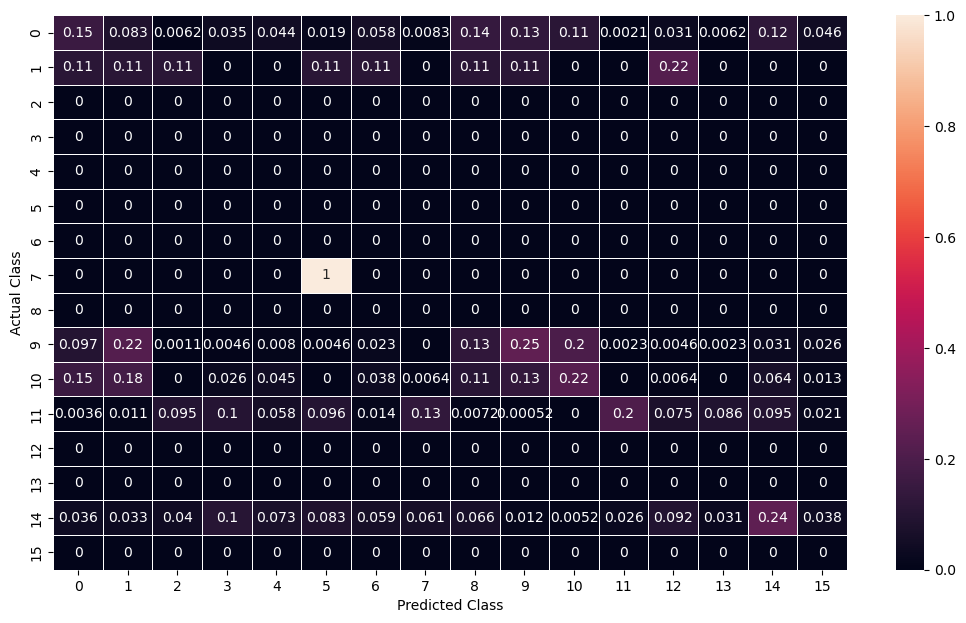

In [9]:

px = 1/plt.rcParams['figure.dpi']  # pixels per inch
plt.subplots(figsize=(1280*px, 720*px))

ax = sns.heatmap(c_matrix, linewidth=.6, annot=True,)
# plt.savefig(f'results/180_matrix')
plt.show()

## learning curve

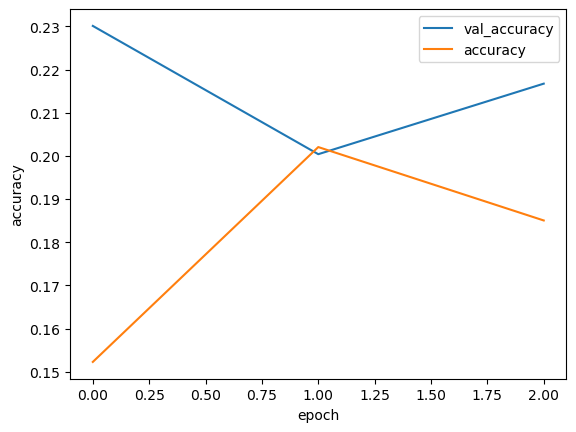

In [10]:
plt.plot('val_accuracy', data=history)
plt.plot('accuracy', data=history)
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.legend()

# plt.savefig(f'results/GRU_curve')
plt.show()